train unzipped.
test unzipped.
submission unzipped.

=== XGBoost ===

--- Fold 1/5 ---


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.77143
[100]	validation_0-auc:0.84352
[200]	validation_0-auc:0.85335
[300]	validation_0-auc:0.86197
[400]	validation_0-auc:0.86924
[500]	validation_0-auc:0.87583
[600]	validation_0-auc:0.88061
[700]	validation_0-auc:0.88304
[800]	validation_0-auc:0.88533
[900]	validation_0-auc:0.88703
[1000]	validation_0-auc:0.88856
[1100]	validation_0-auc:0.88967
[1199]	validation_0-auc:0.89057

--- Fold 2/5 ---
[0]	validation_0-auc:0.76911
[100]	validation_0-auc:0.84912
[200]	validation_0-auc:0.85767
[300]	validation_0-auc:0.86524
[400]	validation_0-auc:0.87303
[500]	validation_0-auc:0.87891
[600]	validation_0-auc:0.88312
[700]	validation_0-auc:0.88572
[800]	validation_0-auc:0.88785
[900]	validation_0-auc:0.88983
[1000]	validation_0-auc:0.89128
[1100]	validation_0-auc:0.89239
[1199]	validation_0-auc:0.89330

--- Fold 3/5 ---
[0]	validation_0-auc:0.77058
[100]	validation_0-auc:0.84759
[200]	validation_0-auc:0.85654
[300]	validation_0-auc:0.86445
[400]	validation_0-auc:0.87232
[50

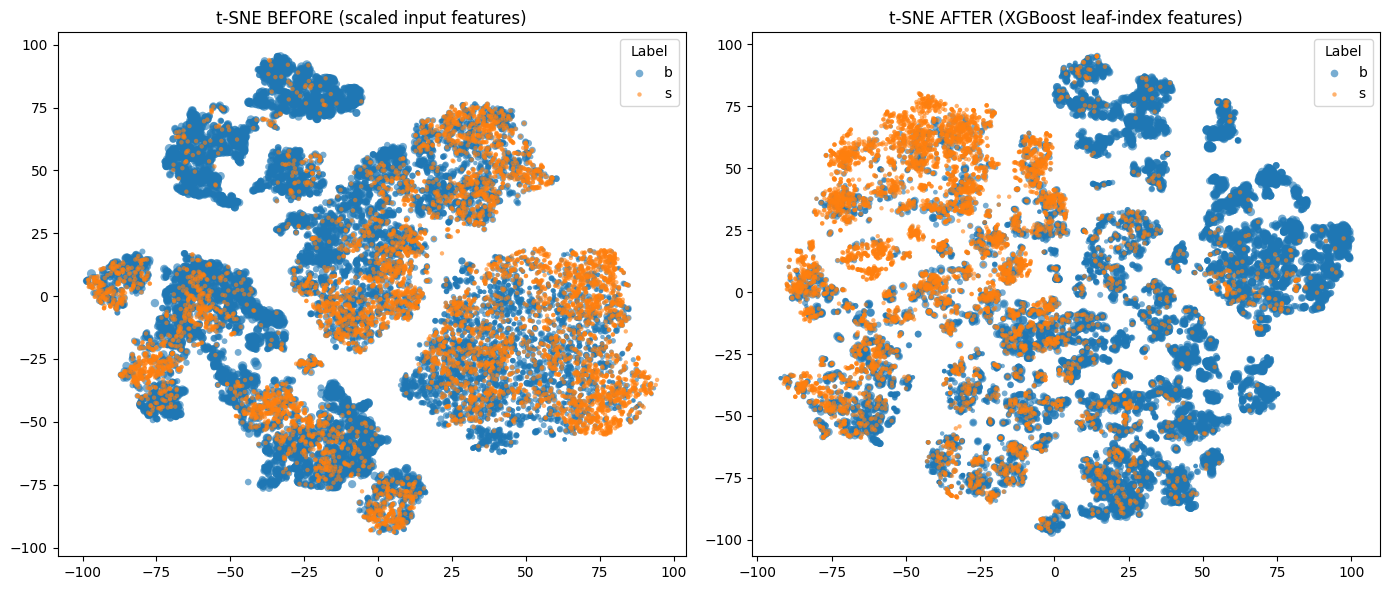

t-SNE visualization complete.


In [1]:
# ===============================================================
# HIGGS BOSON — XGBoost only + t-SNE before/after plots
# ===============================================================

import os, math, zipfile
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ---------------- Settings ----------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
N_FOLDS = 5

# t-SNE settings
SUBSAMPLE_TSNE = 20000  # max samples to run t-SNE on (adjust to your RAM/CPU)
TSNE_PERPLEXITY = 30
TSNE_N_ITER = 1000
TSNE_RANDOM_STATE = SEED

# ---------------- Kaggle File Handling ----------------
zip_files = {
    "train": "/kaggle/input/higgs-boson/training.zip",
    "test":  "/kaggle/input/higgs-boson/test.zip",
    "submission": "/kaggle/input/higgs-boson/random_submission.zip"
}
extract_dir = "/kaggle/working/higgs_data/"
os.makedirs(extract_dir, exist_ok=True)
for key, path in zip_files.items():
    if os.path.exists(path):
        with zipfile.ZipFile(path, "r") as z:
            z.extractall(extract_dir)
            print(f"{key} unzipped.")
    else:
        print(f"{key} zip not found at {path}")

TRAIN_CSV = os.path.join(extract_dir, "training.csv")
TEST_CSV  = os.path.join(extract_dir, "test.csv")
OUT_SUB  = "/kaggle/working/submission.csv"

# ---------------- AMS Metric ----------------
def ams_score(s, b):
    b_reg = 10.0
    rad = 2.0 * ((s + b + b_reg) * math.log(1.0 + s / (b + b_reg)) - s)
    return math.sqrt(rad) if rad > 0 else 0.0

# ---------------- Load Data ----------------
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

# Replace missing sentinel and create missing flags
train_df.replace(-999.0, np.nan, inplace=True)
test_df.replace(-999.0, np.nan, inplace=True)

for c in train_df.columns:
    if c in ['EventId','Weight','Label']: continue
    if train_df[c].isna().any():
        train_df[c+'_miss'] = train_df[c].isna().astype(int)
        test_df[c+'_miss']  = test_df[c].isna().astype(int)

numeric_cols = [c for c in train_df.select_dtypes(include=np.number).columns if c != "Weight"]
train_df[numeric_cols] = train_df[numeric_cols].fillna(train_df[numeric_cols].median())
num_cols_test = [c for c in numeric_cols if c in test_df.columns]
test_df[num_cols_test] = test_df[num_cols_test].fillna(train_df[num_cols_test].median())

# Add derived features (same as original)
if {'DER_mass_MMC','DER_mass_vis'}.issubset(train_df.columns):
    train_df['mass_ratio'] = train_df['DER_mass_MMC']/(train_df['DER_mass_vis']+1e-6)
    test_df['mass_ratio']  = test_df['DER_mass_MMC']/(test_df['DER_mass_vis']+1e-6)
if {'PRI_tau_pt','PRI_met'}.issubset(train_df.columns):
    train_df['pt_ratio'] = train_df['PRI_tau_pt']/(train_df['PRI_met']+1e-6)
    test_df['pt_ratio']  = test_df['PRI_tau_pt']/(test_df['PRI_met']+1e-6)

# Targets, weights, ids
y = (train_df['Label'] == 's').astype(int).values
weights = train_df['Weight'].values
event_ids_test = test_df['EventId'].values

# Features
train_features = train_df.drop(columns=['EventId','Weight','Label'], errors='ignore')
test_features  = test_df.drop(columns=['EventId'], errors='ignore')

# Scaling (same as original)
scaler = StandardScaler()
X = scaler.fit_transform(train_features.values.astype(np.float32))
X_test = scaler.transform(test_features.values.astype(np.float32))

kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

# ---------------- Containers ----------------
oof_xgb = np.zeros(len(X))
test_pred_xgb_folds = []
xgb_models = []  # store models (we'll reuse the last one for leaf embedding)

# ---------------- XGBoost (only model) ----------------
print("\n=== XGBoost ===")
for fold, (tr_idx, va_idx) in enumerate(kf.split(X, y)):
    print(f"\n--- Fold {fold+1}/{N_FOLDS} ---")
    X_tr, X_va = X[tr_idx], X[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]
    w_tr, w_va = weights[tr_idx], weights[va_idx]

    xgbm = xgb.XGBClassifier(
        n_estimators=1200,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        use_label_encoder=False,
        tree_method='hist',
        eval_metric='auc',
        random_state=SEED
    )

    # Fit with early stopping using evaluation set, pass sample weights if desired
    xgbm.fit(
        X_tr, y_tr,
        sample_weight=w_tr,
        eval_set=[(X_va, y_va)],
        early_stopping_rounds=50,
        verbose=100
    )

    xgb_models.append(xgbm)

    # OOF and test predictions
    oof_xgb[va_idx] = xgbm.predict_proba(X_va)[:,1]
    test_pred_xgb_folds.append(xgbm.predict_proba(X_test)[:,1])

# Average test predictions across folds
test_pred_xgb = np.mean(test_pred_xgb_folds, axis=0)

# ---------------- Evaluation & Threshold search (AMS) ----------------
thr_range = np.linspace(0.01, 0.99, 99)
best_thr, best_ams = 0.5, -1
for t in thr_range:
    s = weights[(y==1) & (oof_xgb > t)].sum()
    b = weights[(y==0) & (oof_xgb > t)].sum()
    sc = ams_score(s, b)
    if sc > best_ams:
        best_ams, best_thr = sc, t

print(f"\nBest AMS on XGBoost OOF = {best_ams:.6f} @ thr={best_thr:.4f}")
print("CV AUC (OOF):", roc_auc_score(y, oof_xgb))

# ---------------- Submission ----------------
print("\nWriting submission...")
rankorder = np.argsort(np.argsort(test_pred_xgb)) + 1
classes = np.where(test_pred_xgb > best_thr, 's', 'b')
sub = pd.DataFrame({"EventId": event_ids_test, "RankOrder": rankorder, "Class": classes})
sub.to_csv(OUT_SUB, index=False)
print("Saved submission to:", OUT_SUB)
print("Done.")

# ---------------- t-SNE visualizations (before / after) ----------------
# We'll produce two t-SNE plots:
#  - "Before": t-SNE on the scaled input features (X)
#  - "After" : t-SNE on model-transformed representation using XGBoost leaf indices (xgb.apply)
#
# To keep things manageable we subsample stratified by label up to SUBSAMPLE_TSNE samples.

print("\nPreparing t-SNE visualizations...")

n_samples = X.shape[0]
subsample_size = min(SUBSAMPLE_TSNE, n_samples)

# stratified subsample
if subsample_size < n_samples:
    strat_idx = train_test_split(
        np.arange(n_samples),
        train_size=subsample_size,
        stratify=y,
        random_state=SEED
    )[0]
else:
    strat_idx = np.arange(n_samples)

X_sub = X[strat_idx]
y_sub = y[strat_idx]
w_sub = weights[strat_idx]

# BEFORE: t-SNE on scaled features
print("Running t-SNE (before) on scaled features... this can take a while for large samples.")
tsne_before = TSNE(
    n_components=2,
    perplexity=min(TSNE_PERPLEXITY, max(5, (len(X_sub) - 1) // 3)),
    n_iter=TSNE_N_ITER,
    random_state=TSNE_RANDOM_STATE,
    init='pca',
    verbose=1
)
X_emb_before = tsne_before.fit_transform(X_sub)

# AFTER: obtain leaf indices from one of the trained XGB models and run t-SNE on that representation
# We'll reuse the last-trained fold model (xgb_models[-1]) to produce leaf indices for all samples.
# apply() returns an (n_samples, n_trees) integer array giving leaf index per tree.
print("Computing leaf indices from trained XGBoost model (for 'after' representation)...")
last_model = xgb_models[-1]
leaf_indices_full = last_model.apply(X)  # shape: (n_samples, n_trees)
# Subsample rows to match X_sub
leaf_indices_sub = leaf_indices_full[strat_idx]

# convert leaf indices to float for t-SNE; optionally one-hot would be larger and slower.
# Using the leaf index matrix (as continuous-ish ints) often gives a meaningful embedding.
print("Running t-SNE (after) on leaf-index features... this can also take a while.")
tsne_after = TSNE(
    n_components=2,
    perplexity=min(TSNE_PERPLEXITY, max(5, (len(leaf_indices_sub) - 1) // 3)),
    n_iter=TSNE_N_ITER,
    random_state=TSNE_RANDOM_STATE,
    init='pca',
    verbose=1
)
X_emb_after = tsne_after.fit_transform(leaf_indices_sub.astype(float))

# ---------------- Plotting ----------------
print("Plotting t-SNE results...")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# plotting helper
def scatter_ax(ax, emb, labels, weights=None, title=""):
    lab_vals = np.unique(labels)
    for lv in lab_vals:
        mask = (labels == lv)
        lbl_name = 's' if lv == 1 else 'b'
        # marker size controlled by weight (scaled) if available
        if weights is not None:
            sizes = 10 + (weights[mask] / (weights.max() + 1e-9)) * 40
        else:
            sizes = 10
        ax.scatter(emb[mask, 0], emb[mask, 1], s=sizes, alpha=0.6, label=lbl_name, linewidths=0)
    ax.set_title(title)
    ax.legend(title='Label')

scatter_ax(axes[0], X_emb_before, y_sub, weights=w_sub, title="t-SNE BEFORE (scaled input features)")
scatter_ax(axes[1], X_emb_after, y_sub, weights=w_sub, title="t-SNE AFTER (XGBoost leaf-index features)")

plt.tight_layout()
plt.show()

print("t-SNE visualization complete.")
